# Unsupervised Audio Separation
# Adhémar de Senneville

The following code was not asked,

----
# Imports and Paths

In [2]:
# Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import IPython.display as ipd

# Imports Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchaudio
import torch.nn as nn
from torch.utils.data import random_split
import gc
import librosa
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
from matplotlib import pyplot as plt


# Path for the Kaggle input directory
kaggle = True
project_name = "Unsupervised-Audio-Separation"

input_path = '/kaggle/input'

def transform_path(local_path):
    # Define the local base path and the Kaggle base path
    local_base_path = "D:/dataset/Libri2Mix_min16k"
    kaggle_base_path = "/kaggle/input/libri2mix-min16k"

    # Replace the local base path with the Kaggle base path
    if local_path.startswith(local_base_path):
        return local_path.replace(local_base_path, kaggle_base_path)[:-1]
    else:
        return local_path  # or handle the error if the path does not start with the local base path


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Weights and Bias

In [3]:
!pip install wandb onnx -Uq
import wandb

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

API_Key = ""
os.environ["WANDB_API_KEY"] = API_Key
wandb.login()

wandb: Currently logged in as: adhemar-senneville (team-de-fou). Use `wandb login --relogin` to force relogin


True

In [4]:
training_instruction = {"PIT":False,
                        "MixIT":False,
                        "MixPIT":True,
                        "MixCycle":False,
                        "MixPITD":False}

----
# The Data

In [5]:
class AudioSeparationDataset(Dataset):
    def __init__(self, list_path, mode="PIT"):
        self.clean_list_path = list_path + "clean.scp"
        self.noisy_list_path = list_path + "noisy.scp"
        modes = ["PIT","MixIT","MixPIT","MixCycle"]
        self.mode = mode
        self.filtering = False
        self.sr = 16000
        self.pairs_list = self._load_pairs_list()

    def _load_pairs_list(self):
        # Load clean and noisy file lists
        with open(self.clean_list_path, 'r') as clean_file, open(self.noisy_list_path, 'r') as noisy_file:
            clean_list = clean_file.readlines()
            noisy_list = noisy_file.readlines()

        # Pair clean and noisy files (assuming they are in the same order)
        return list(zip(clean_list, noisy_list))

    def __len__(self):
        return len(self.pairs_list)

    def __getitem__(self, idx):
        clean_path, noisy_path = self.pairs_list[idx]
        

        if self.mode == "MixIT" or self.mode == "MixPIT" or self.mode == "MixCycle":
            # Select a random index different from idx
            random_idx = random.choice([i for i in range(len(self.pairs_list)) if i != idx])
            _, other_noisy_path = self.pairs_list[random_idx]

            # Load the noisy waveforms
            noisy_waveform, _ = torchaudio.load(transform_path(noisy_path))
            other_noisy_waveform, _ = torchaudio.load(transform_path(other_noisy_path))

            # Determine the lengths of the waveforms
            len_noisy = noisy_waveform.shape[1]
            len_other_noisy = other_noisy_waveform.shape[1]

            # Find the longest and shortest waveform
            longest_len = max(len_noisy, len_other_noisy)
            shortest_waveform = noisy_waveform if len_noisy < len_other_noisy else other_noisy_waveform

            # Calculate padding needed for the shortest waveform
            total_padding = longest_len - shortest_waveform.shape[1]
            left_padding = 0
            right_padding = total_padding - left_padding

            # Pad the shortest waveform
            padded_waveform = torch.nn.functional.pad(shortest_waveform, (left_padding, right_padding))

            # Update the original variable to the padded waveform if necessary
            if len_noisy < len_other_noisy:
                noisy_waveform = padded_waveform
            else:
                other_noisy_waveform = padded_waveform
            
            #print("Filtering")
            if self.filtering:
                print("Filtering")
                noisy_waveform, other_noisy_waveform = self.filter(noisy_waveform, other_noisy_waveform)

            return noisy_waveform, other_noisy_waveform
        elif self.mode == "PIT":
            # Load the audio files
            clean_waveform, _ = torchaudio.load(transform_path(clean_path))
            noisy_waveform, _ = torchaudio.load(transform_path(noisy_path))
            
            max_size = max(clean_waveform.size(1), noisy_waveform.size(1))

            # Pad the shorter waveform
            if clean_waveform.size(1) < max_size:
                # Pad clean waveform
                padding_size = max_size - clean_waveform.size(1)
                clean_waveform = torch.nn.functional.pad(clean_waveform, (0, padding_size))
            else:
                # Pad noisy waveform
                padding_size = max_size - noisy_waveform.size(1)
                noisy_waveform = torch.nn.functional.pad(noisy_waveform, (0, padding_size))
            # In supervised mode, return the clean and noisy waveforms
            return clean_waveform, noisy_waveform
        else:
            raise "Not Implemented Error"
    
    
    def filter(self,noisy_waveform, other_noisy_waveform):
        
        def random_bandpass_filter(audio, sr):
            # Define random frequencies for the band-pass filter
            low_freq = random.randint(300, 1500)  # Lower frequency bound (in Hz)
            high_freq = random.randint(1700, 4000)  # Upper frequency bound (in Hz)

            audio = torchaudio.functional.highpass_biquad(audio,
                sample_rate=sr,
                cutoff_freq=low_freq
            )

            # Create the low-pass filter to remove frequencies above high_freq
            audio = torchaudio.functional.lowpass_biquad(audio,
                sample_rate=sr,
                cutoff_freq=high_freq
            )

            return audio
        
        sr = self.sr
        # Apply the band-pass filter to both waveforms
        noisy_waveform = random_bandpass_filter(noisy_waveform, sr)
        other_noisy_waveform = random_bandpass_filter(other_noisy_waveform, sr)

        return noisy_waveform, other_noisy_waveform

    def listen_to_pair(self, idx, model = None):
        
        print("Mode :",self.mode)
        
        def plot_stft(audio, sr=16000, title="STFT"):
            
            f, t, Zxx = signal.stft(audio, fs=sr, nperseg=512)
            #plt.pcolormesh(t, f, np.abs(Zxx))
            plt.figure(figsize=(10, 6))
            plt.pcolormesh(t, np.where(f == 0, f[1], f), 10*np.log(np.abs(Zxx)+1e-9), shading='gouraud')  # Éviter log(0) en utilisant f[1] à la place de 0
            plt.yscale('log')  # Échelle logarithmique pour l'axe des y
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.title(title)
            plt.colorbar(format='%+2.0f dB')
            plt.show()
        
        if model == None:
        
            waveform1, waveform2 = self[idx]
            
            print("Dataset samples:")
            display(ipd.Audio(waveform1.numpy(), rate=16000))  # Assuming sample rate is 16kHz
            display(ipd.Audio(waveform2.numpy(), rate=16000))  # Modify as needed for different sample rates
            
            plot_stft(waveform1[0].numpy(), title="STFT 1")
            plot_stft(waveform2[0].numpy(), title="STFT 2")
            
            return waveform1[0].numpy(), waveform2[0].numpy()
        
        elif self.mode == "PIT":
            s, x = self[idx]
            device = next(model.parameters()).device
            s_predicted = model((x).unsqueeze(0).to(device))[0].cpu()
            print(s_predicted.shape)
            
            print("Mixture of sources:")
            display(ipd.Audio((s).numpy(), rate=16000))
            display(ipd.Audio((x-s).numpy(), rate=16000))
            print("Estimated Sources:")
            display(ipd.Audio(s_predicted[0].detach().numpy(), rate=16000))
            display(ipd.Audio(s_predicted[1].detach().numpy(), rate=16000))
            
            plot_stft(waveform1.numpy(), title="STFT 1")
            plot_stft(waveform2.numpy(), title="STFT 2")
            
            return s_predicted[0].detach().numpy(), s_predicted[1].detach().numpy()
            

def collate_fn(batch):
    # 'batch' is a list of tuples where each tuple is (audio_data, label)
    audio_1, audio_2 = zip(*batch)

    # Pad the sequences to the max length in the batch
    audio_1 = [a.squeeze(0) for a in audio_1]
    audio_2 = [a.squeeze(0) for a in audio_2]
    audio_1_padded = pad_sequence(audio_1, batch_first=True, padding_value=0)
    audio_2_padded = pad_sequence(audio_2, batch_first=True, padding_value=0)
    audio_1_padded = audio_1_padded.unsqueeze(1)
    audio_2_padded = audio_2_padded.unsqueeze(1)

    return audio_1_padded, audio_2_padded
# Example usage
dataset_train = AudioSeparationDataset(input_path + '/libri2mix-min16k/SE/dev/',
                                 mode="PIT")

dataset_test = AudioSeparationDataset(input_path + '/libri2mix-min16k/SE/test/',
                                 mode="PIT")

# Set the proportion for splitting
train_size = int(0.8 * len(dataset_train))  # 80% for training
valid_size = len(dataset_train) - train_size  # 20% for validation

# Split the dataset
dataset_train, dataset_valid = random_split(dataset_train, [train_size, valid_size])

print(f"Dataset Train Length: {len(dataset_train)}")
print(f"Dataset Valid Length: {len(dataset_valid)}")
print(f"Dataset Test  Length: {len(dataset_test)}")

sample_clean, sample_noisy = dataset_train[0]
print(f"Shape of a sample clean waveform: {sample_clean.shape}")
print(f"Shape of a sample noisy waveform: {sample_noisy.shape}")

num_files_to_show = 1
print("Names of some audio files:")
for idx in range(num_files_to_show):
    clean_path, noisy_path = dataset_test.pairs_list[idx]
    print(f"Clean Path: {clean_path}")
    print(f"Noisy Path: {noisy_path}")



Dataset Train Length: 2400
Dataset Valid Length: 600
Dataset Test  Length: 3000
Shape of a sample clean waveform: torch.Size([1, 81120])
Shape of a sample noisy waveform: torch.Size([1, 81120])
Names of some audio files:
Clean Path: D:/dataset/Libri2Mix_min16k/test/s1/1089-134686-0000_121-127105-0031.wav

Noisy Path: D:/dataset/Libri2Mix_min16k/test/mix_single/1089-134686-0000_121-127105-0031.wav



In [6]:
if False:
    os.chdir('/kaggle/working')
    !git clone https://github.com/ertug/MixCycle.git
    os.chdir('/kaggle/working')

## Testing

Mode : MixIT
Dataset samples:


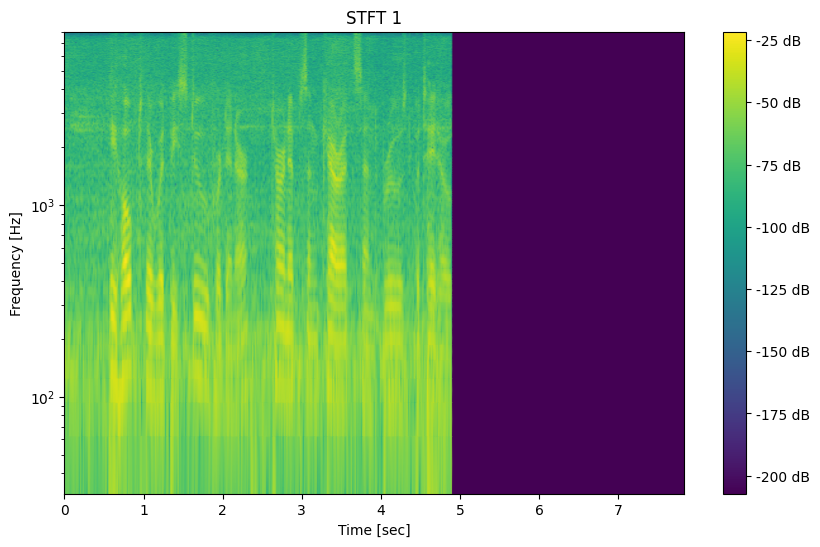

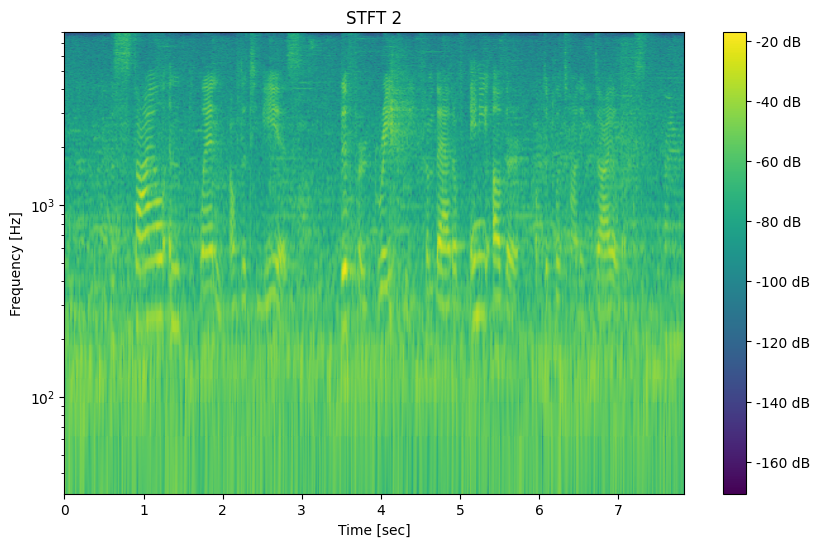

Mode : MixIT
Filtering
Dataset samples:


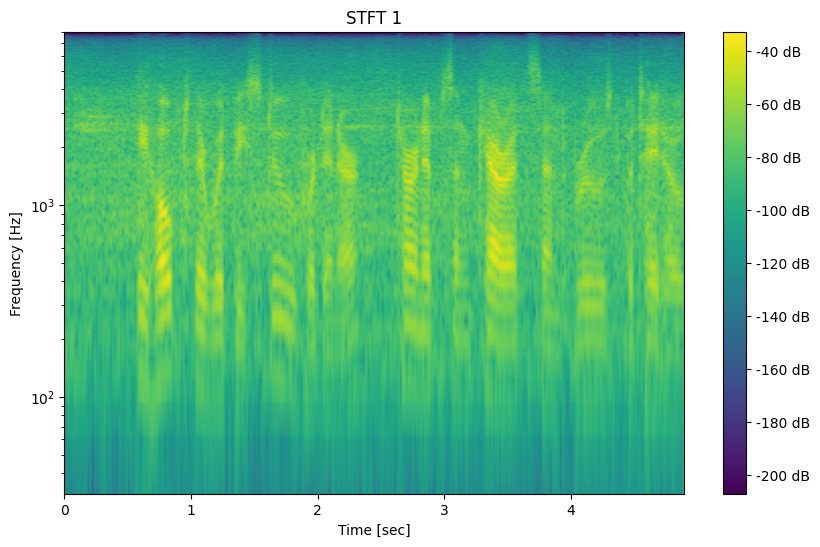

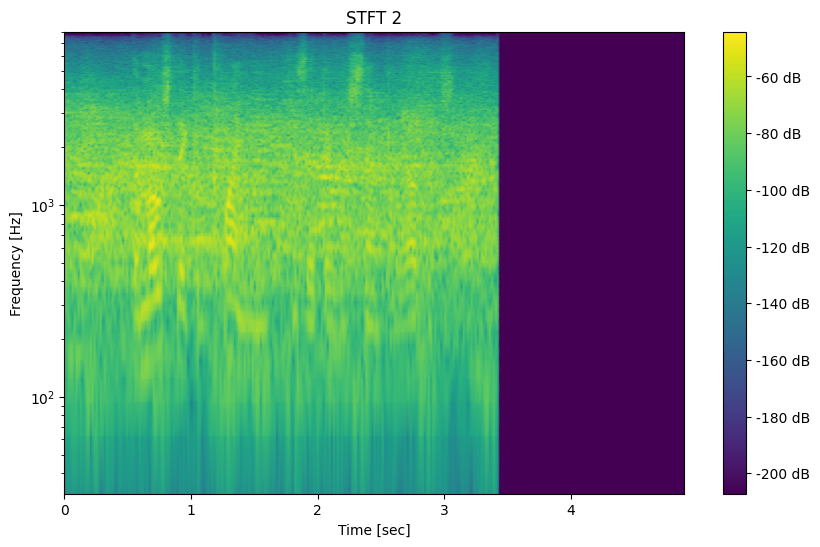

Mode : PIT
Dataset samples:


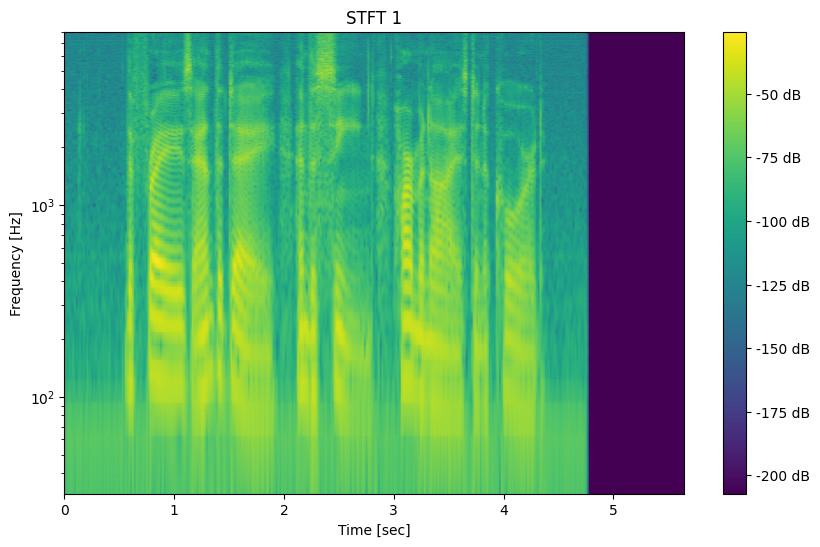

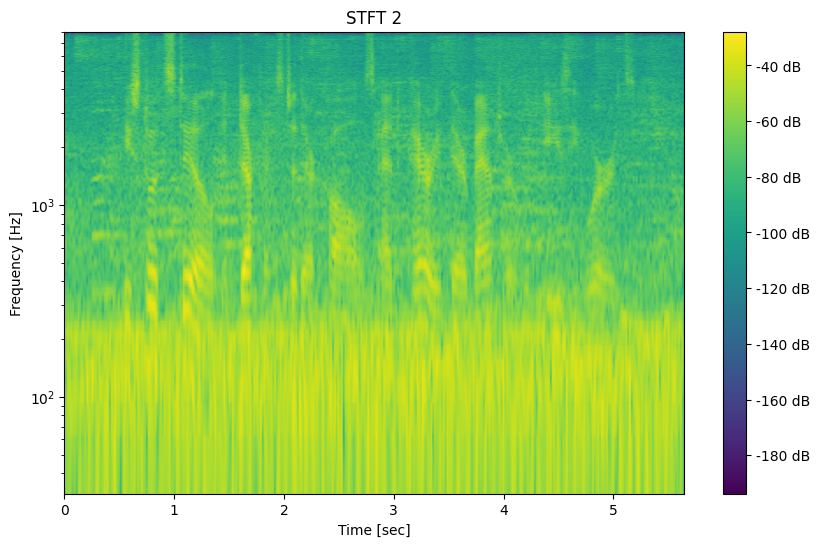

In [24]:
dataset_test.mode = "MixIT"
dataset_test.filtering = False
dataset_test.listen_to_pair(1)

dataset_test.mode = "MixIT"
dataset_test.filtering = True
dataset_test.listen_to_pair(1)

dataset_test.mode = "PIT"
v, x = dataset_test.listen_to_pair(65)

## Utils Functions

In [9]:
def plot_stft(audio, sr=16000, title="STFT"):
            
            f, t, Zxx = signal.stft(audio, fs=sr, nperseg=512)
            #plt.pcolormesh(t, f, np.abs(Zxx))
            plt.figure(figsize=(10, 6))
            plt.pcolormesh(t, np.where(f == 0, f[1], f), 10*np.log(np.abs(Zxx)+1e-9), shading='gouraud')  # Éviter log(0) en utilisant f[1] à la place de 0
            plt.yscale('log')  # Échelle logarithmique pour l'axe des y
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.title(title)
            plt.colorbar(format='%+2.0f dB')
            plt.show()
n = x - v

def compute_psd(signal, fs):
    """
    Compute the Power Spectral Density (PSD) of a signal.
    
    :param signal: Input signal.
    :param fs: Sampling frequency.
    :return: Frequency bins and PSD of the signal.
    """
    f, psd = np.fft.rfftfreq(signal.size, 1/fs), np.abs(np.fft.rfft(signal))**2 / signal.size
    return f, psd

def wiener_filter(x, fs, psd_v, psd_n):
    """
    Apply the Wiener filter to denoise the signal.
    
    :param x: The observed signal (n + v).
    :param fs: Sampling frequency.
    :param psd_v: Power Spectral Density of the voice signal.
    :param psd_n: Power Spectral Density of the noise signal.
    :return: The estimated clean voice signal.
    """
    # FFT of the observed signal
    x_fft = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(len(x), 1/fs)
    
    # Interpolate PSDs to match the observed signal's frequency bins
    psd_v_interp = np.interp(freqs, *compute_psd(psd_v, fs))
    psd_n_interp = np.interp(freqs, *compute_psd(psd_n, fs))
    
    # Compute the Wiener filter gain
    H = psd_v_interp / (psd_v_interp + psd_n_interp)
    
    # Apply the Wiener filter
    y_fft = H * x_fft
    y = np.fft.irfft(y_fft)
    
    return y


v_estimated = wiener_filter(x, 16000,v, n)



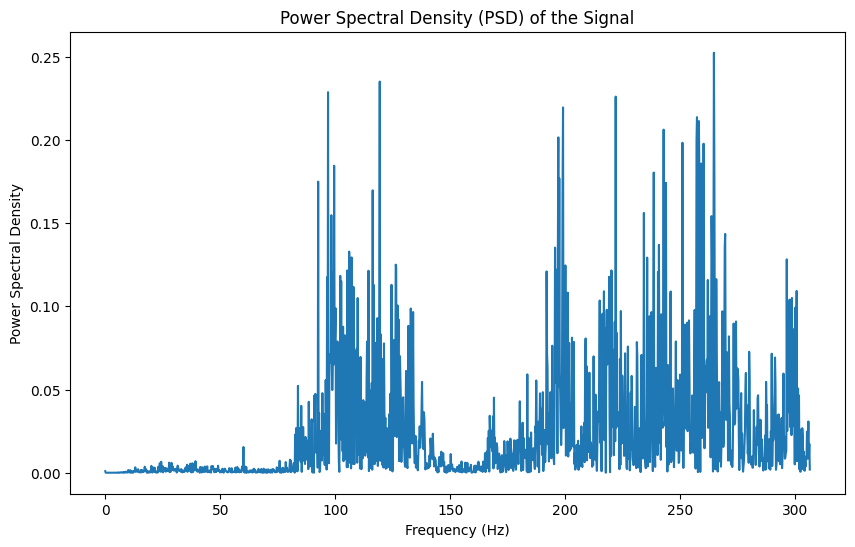

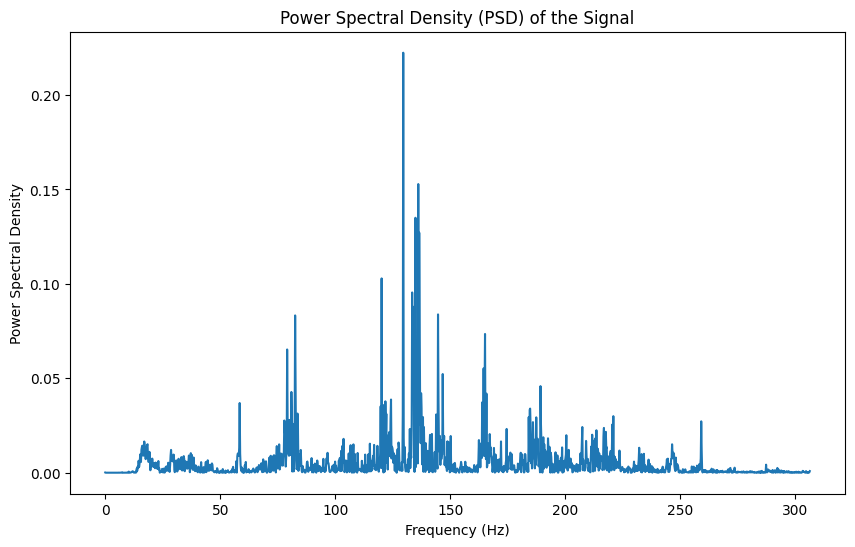

In [22]:
def plot_psd(signal, fs = 16000):
    f, psd = compute_psd(signal, fs)
    plt.figure(figsize=(10, 6))
    plt.plot(f[:1500], psd[:1500])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('Power Spectral Density (PSD) of the Signal')
    plt.show()

plot_psd(v)
plot_psd(n)

----
# Losses

In [69]:
def sisnr(true_wave, pred_wave, snr_max=30):
    eps = 10**(-snr_max/10)
    true_wave = ((true_wave * pred_wave).sum(-1) / (true_wave.square().sum(-1))).unsqueeze(-1) * true_wave

    return 10 * torch.log10(true_wave.square().sum(-1) / ((true_wave - pred_wave).square().sum(-1) + eps*true_wave.square().sum(-1) + 1e-9))

""" MSE testing...
def sisnr(true_wave, pred_wave, snr_max=30):
    
    true_wave = ((true_wave * pred_wave).sum(-1) / (true_wave.square().sum(-1))).unsqueeze(-1) * true_wave
    
    return -(true_wave - pred_wave).square().mean(-1)
"""

In [72]:
def loss_PIT(s_pred,s_1,s_2):
    loss_permutation_1 = sisnr(s_1[:,0],s_pred[:,0])+sisnr(s_2[:,0],s_pred[:,1])
    loss_permutation_2 = sisnr(s_1[:,0],s_pred[:,1])+sisnr(s_2[:,0],s_pred[:,0])
    
    loss, _ = torch.min(torch.stack([-loss_permutation_1,-loss_permutation_2],dim = 1),dim = 1)
    return torch.mean(loss)

In [77]:
# Same approch as MixIT where all A matrices are tested
def create_permutation_matrice(n,M=4):
    A = torch.zeros((2,M))
    for m in range(M):
        index = (n//(2**m))%2
        A[index,m]=1
    return A

def loss_MixIT(s_pred,x_1,x_2):
    
    batch_size = s_pred.shape[0]
    arrange_size =2**(s_pred.shape[1])
    device = s_pred.device
    
    losses = torch.empty([batch_size,arrange_size], device=device)
    
    for n in range(arrange_size):
        
        A = create_permutation_matrice(n)
        #print(A.shape,s_pred.shape)
        s_pred_permute = A.matmul(s_pred)
        #print(sisnr(x_1[:,0],s_pred_permute[:,0])[0])
        if torch.isnan(sisnr(x_1[:,0],s_pred_permute[:,0])[0]):
            print("x",x_1[:,0].shape,x_1[:,0])
            print("s",s_pred_permute[:,0].shape,s_pred_permute[:,0])
        losses[:,n] = - sisnr(x_1[:,0],s_pred_permute[:,0]) - sisnr(x_2[:,0],s_pred_permute[:,1])
    
    #print(losses)
    
    losses, _ = torch.min(losses,dim=1)
    return torch.mean(losses)


## Testing

### SISNR

In [ ]:
yo_1 = torch.rand(3,4000)
yo_2 = torch.rand(3,4000)
yo_2 = yo_1

sisnr(yo_1,yo_2,),sisnr(yo_1,yo_2*3,),sisnr(yo_1,yo_2*2,),

### PIT

In [ ]:
yo_1 = torch.rand(3,1,4000)
yo_2 = torch.rand(3,1,4000)
yo_pred = torch.cat([yo_1,yo_2],dim = 1)
print(yo_pred.shape)

loss_PIT(yo_pred,yo_1,yo_2)

In [ ]:
yo_s, yo_x = dataset_test[1]

yo_1 = yo_s
yo_2 = yo_x - yo_s
yo_1 = yo_1.unsqueeze(0)
yo_2 = yo_2.unsqueeze(0)

yo_pred = torch.cat([yo_1,yo_2],dim = 1)
print(yo_pred.shape,yo_1.shape,yo_2.shape)

#display(ipd.Audio(yo_1.squeeze(0).detach().numpy(), rate=16000))
#display(ipd.Audio(yo_2.squeeze(0).detach().numpy(), rate=16000))
#display(ipd.Audio(yo_s.squeeze(0).detach().numpy(), rate=16000))
#display(ipd.Audio(yo_x.squeeze(0).detach().numpy(), rate=16000))

loss_PIT(yo_pred,yo_1,yo_2),loss_PIT(yo_pred,3*yo_2,yo_1)

### MixIT

In [78]:
s_i_yo = torch.rand(3,1,4000)
s_j_yo = torch.rand(3,1,4000)
s_k_yo = torch.rand(3,1,4000)
s_l_yo = torch.rand(3,1,4000)
x_ij = s_i_yo + s_j_yo
x_kl = s_k_yo + s_l_yo
s_pred_yo_2 = torch.rand(3,4,4000)
liste = [s_i_yo, s_j_yo, s_k_yo, s_l_yo]
random.shuffle(liste)
s_pred_yo_1 = torch.cat(liste,dim = 1)

print(loss_MixIT(s_pred_yo_1,x_ij,x_kl))
#print(loss_MixIT(s_pred_yo_2,x_ij,x_kl))

tensor(0.)


----
# Models

In [79]:
import torch
import torchaudio

def initialize_weights(m):
    if isinstance(m, torch.nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

class ConvTasnet(torch.nn.Module):
    def __init__(self, num_sources=2):
        super().__init__()
        self.convtasnet = torchaudio.models.ConvTasNet(num_sources=num_sources,
                                                       enc_kernel_size=8,
                                                       enc_num_feats=256,
                                                       msk_kernel_size=3,
                                                       msk_num_feats=128,
                                                       msk_num_hidden_feats=256,
                                                       msk_num_layers=8,
                                                       msk_num_stacks=2)

        # Apply custom weight initialization
        self.convtasnet.apply(initialize_weights)

    def forward(self, x):
        out = self.convtasnet(x)
        return out

In [80]:
if True:
    with torch.no_grad():
        model = ConvTasnet(num_sources = 2)
        input_mix = torch.randn(3, 1, 80000, requires_grad=True)
        output = model(input_mix)
        print("Input  :",input_mix.shape)
        print("Output :",output.shape)
        loss = loss_PIT(output,input_mix/2,input_mix/2)
        del model; del input_mix; del output; gc.collect()

Input  : torch.Size([3, 1, 80000])
Output : torch.Size([3, 2, 80000])


In [81]:
class HybridDemucs(nn.Module):
    def __init__(self):
        super().__init__()
        self.hdemucs = torchaudio.models.HDemucs(["mixture", "vocals"], audio_channels=1)

    def forward(self, x):
        out = self.hdemucs(x)
        return out.squeeze(-2)

In [82]:
if True:
    with torch.no_grad():
        model = HybridDemucs()
        input_mix = torch.randn(3, 1, 80000, requires_grad=True)
        output = model(input_mix)
        print("Input  :",input_mix.shape)
        print("Output :",output.shape)

Input  : torch.Size([3, 1, 80000])
Output : torch.Size([3, 2, 80000])


----
# Training

In [84]:
all_metrics = {}

## Functions

In [85]:
class color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = '\033[1;32;48m'
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

import IPython
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

class ProgressTrain():
    def __init__(self,imax,Size=50, num_update=100,names = [],epoch_names = ["Train","Test"],time_sleep = 0.01):
        self.imax=imax
        self.i=0
        self.Scale=Size/imax
        self.Size=Size
        self.value_hist = []
        self.names = names
        self.update_rate = int(imax//num_update+1)
        self.epoch = 1
        self.time_sleep = 0.01

        self.out = display(IPython.display.Pretty('Starting'), display_id=True) #
        time.sleep(0.5)

        self.colorList=[color.RED,color.YELLOW,color.PURPLE,color.BLUE,color.CYAN,color.GREEN]
        self.colorList=[x.replace('8m','8m') for x in self.colorList]

        string = ""
        for name in ["Remaining Time"]+names:
            string += self.show(name,n = max(9,len(name))) + ' || '

        epoch_string = ""
        for name in epoch_names:
            epoch_string += self.show(name) + ' || '
        self.epoch_names = ["Train Loss","Test Loss"] + epoch_names

        print("-"*(Size+10)+"|| "+string)
        if epoch_string == "":
            print("||----||   Epoch   ||          Loss          || ")
            print("||----||   Time    ||   Train   ||   Test    || ")
        else:
            print("||----||   Epoch   ||          Loss          || "+"Others".center(len(epoch_string)-4)+" ||")
            print("||----||   Time    ||   Train   ||   Test    || "+epoch_string)
        time.sleep(0.5)

        self.start_time = time.time()

        self.update()
        
    def update(self,x=[]):
        if self.i%self.update_rate == 0:

            Color=self.colorList[min(len(self.colorList)-1,round(self.i/self.imax*(len(self.colorList)-1)))]

            def format_number(x, n=5):
                return "{:>{width}.2f}".format(x, width=n)
            
            def format_delta_time(delta):
                hours = int(delta // 3600)
                minutes = int((delta % 3600) // 60)
                seconds = int(delta % 60)
                return "{:02}h{:02}m{:02}s".format(hours, minutes, seconds)
            
            if self.i == 0:
                remaining_time = 0
            else:
                remaining_time = (time.time()-self.start_time)*(self.imax/(self.i+0.0001)-1)

            x = [format_delta_time(remaining_time)] + x

            string = Color+'['+'%'*round(self.i*self.Scale)+'-'*round((self.imax-self.i)*self.Scale)+'] '+format_number(100*self.i/(self.imax))+'%'+color.END
            string += color.BOLD
            for value,name in zip(x,["Remaining Time"]+self.names):
                string += ' || '+self.show(value,n = max(9,len(name)))

            string += color.END+' ||   '

            self.out.update(IPython.display.Pretty(string))
            time.sleep(self.time_sleep)
        
        self.i+=1

    def show(self,x,n=9,c=None):
        if n<5:
            assert "To short to show"
        if type(x)==int or type(x)==float:
            if (x>=(10**4) or x<=(10**(-4))) and x >0:
                out = ("{:."+str(n-6)+"e}").format(x)
            elif (x<=-(10**4) or x>=-(10**(-4))) and x < 0:
                out = ("{:."+str(n-7)+"e}").format(x)
            else:
                out = str(x)[:n]
        elif type(x)==str:
            
            if len(x)>n:
                out = x[:n]
            else:
                out = x.center(n)
        else:
            out = str(x)[:n]
        
        if c is None:
            return out + " "*max((n-len(out)),0)
        else:
            return c + out + " "*max((n-len(out)),0) + color.END
        

    def end(self,x=[],kaggle = False):
        self.i-=1

        def format_integer(x, n=3):
            return "{:>{width}}".format(x, width=n)
        
        def format_delta_time(delta):
                hours = int(delta // 3600)
                minutes = int((delta % 3600) // 60)
                seconds = int(delta % 60)
                return "{:02}h{:02}m{:02}s".format(hours, minutes, seconds)
            
        total_time = time.time()-self.start_time

        x = [format_delta_time(total_time)] + x
        
        if self.i==self.imax:
            string = '||'+color.GREEN+format_integer(self.epoch)+color.END #+'' + color.BOLD
            
        else:
            string = color.YELLOW+'||'+format_integer(self.epoch)+color.END+'' + color.BOLD
        for k, value in enumerate(x):
            if self.epoch == 1 or k==0:
                string += ' || '+self.show(value)
            else:
                if value < self.value_hist[-1][k-1]:
                    if k>2:
                        string += ' || '+self.show(value,c = color.RED)
                    else:
                        if value < min(np.array(self.value_hist)[:,k-1]):
                            string += ' || '+self.show(value,c = color.GREEN)
                        else:
                            string += ' || '+self.show(value,c = color.YELLOW)
                elif value > self.value_hist[-1][k-1]:
                    if k>2:
                        if value > max(np.array(self.value_hist)[:,k-1]):
                            string += ' || '+self.show(value,c = color.GREEN)
                        else:
                            string += ' || '+self.show(value,c = color.YELLOW)
                    else:
                        string += ' || '+self.show(value,c = color.RED)
                else:
                    string += ' || '+self.show(value)
        
        string += ' || '
        self.i=0
        self.update()
        self.value_hist.append(x[1:])
        self.epoch += 1
        self.start_time = time.time()

        if kaggle:
            return string
        else:
            print(string)
        

        
    def get(self,input_names):

        data = np.transpose(np.array(self.value_hist))
        if not isinstance(input_names, list):
            input_names = [input_names]
        # Find indices of the input names
        indices = [self.epoch_names.index(name) for name in input_names if name in self.epoch_names]
        # Extract and return the data for these indices
        return [data[index] for index in indices]

    def plot(self, input_names = ["Train Loss","Test Loss"]):
        
        if self.epoch == 1:
            return 0

        data = np.transpose(np.array(self.value_hist))
        # Ensure input_names is a list
        if isinstance(input_names, str):
            input_names = [input_names]
        
        plt.figure(figsize=(10, 4)) 
        # Plot data for each name in input_names
        for name in input_names:
            if name in self.epoch_names:
                index = self.epoch_names.index(name)
                plt.plot(range(1,len(data[index])+1),data[index], label=name)

        # Set plot features
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title(', '.join(input_names)+ " Evolution.")
        plt.legend()
        #plt.grid()
        
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        plt.show()


In [86]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
        elif score >= self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [87]:
def TRAIN():
    try:
        loss_hist = []
        training_mode = train_loader.dataset.dataset.mode
        
        print("Training_mode",training_mode)
        P = ProgressTrain(len(train_loader),epoch_names = [],names = ["Batch Loss","Grad Model"],time_sleep = 0)
        
        
        for epoch in range(max_epoch):

            model.train()  # Set the model to training mode
            
            if training_mode == "MixIT" or training_mode == "MixPIT":

                for x_1, x_2 in train_loader:
                    x_1 = x_1.to(device)
                    x_2 = x_2.to(device)

                    optimizer.zero_grad()
                    
                    x_predicted = model(x_1 + x_2)
                    
                    if training_mode == "MixIT":
                        l = loss_MixIT(x_predicted, x_1, x_2)
                    elif training_mode == "MixPIT":
                        l = loss_PIT(x_predicted, x_1, x_2)
                    l.backward()
                    optimizer.step()

                    # Log training loss
                    loss_hist.append(l.item())

                    mean_grad = sum(p.grad.abs().mean().item() for p in model.parameters() if p.grad is not None) / len([p for p in model.parameters() if p.grad is not None])
                    P.update([l.item(),mean_grad])
                    wandb.log({"train/loss": l.item(), "train/global gradient": mean_grad})
                    
            elif training_mode == "PIT":
                
                for s, x in train_loader:
                    x = x.to(device).float()
                    s = s.to(device).float()

                    optimizer.zero_grad()

                    s_predicted = model(x)
                    
                    #print(s_predicted.shape, s.shape, (x-s).shape)

                    l = loss_PIT(s_predicted, s, x-s)
                    
                    #criterion = torch.nn.MSELoss()
                    #l = criterion(s_predicted[:,0],s[:,0])
                    
                    l.backward()
                    optimizer.step()

                    # Log training loss
                    loss_hist.append(l.item())

                    mean_grad = sum(p.grad.abs().mean().item() for p in model.parameters() if p.grad is not None) / len([p for p in model.parameters() if p.grad is not None])
                    P.update([l.item(),mean_grad])
                    wandb.log({"train/loss": l.item(), "train/global gradient": mean_grad})
                    
            elif training_mode == "MixCycle":
                
                for x_1, x_2 in train_loader:
                    x_1 = x_1.to(device)
                    x_2 = x_2.to(device)

                    optimizer.zero_grad()
                    
                    with torch.no_grad():
                        s_predicted_1 = model(x_1)
                        s_predicted_2 = model(x_2)
                    
                        # Create a random boolean mask for the batch
                        batch_size = s_predicted_1.shape[0]
                        mask = torch.rand(batch_size) < 0.5

                        # Use broadcasting to apply the mask
                        s_tilt_1_1 = torch.where(mask, s_predicted_1[:,0], s_predicted_1[:,1])
                        s_tilt_1_2 = torch.where(mask, s_predicted_2[:,0], s_predicted_2[:,1])
                        x_tilt_1 = s_tilt_1_1 + s_tilt_1_2

                        s_tilt_2_1 = torch.where(mask, s_predicted_1[:,1], s_predicted_1[:,0])
                        s_tilt_2_2 = torch.where(mask, s_predicted_2[:,1], s_predicted_2[:,0])
                        x_tilt_2 = s_tilt_2_1 + s_tilt_2_2
                    
                    
                    s_tilted_predicted_1 = model(x_tilt_1)
                    s_tilted_predicted_2 = model(x_tilt_2)
                    
                    l = loss_PIT(s_tilted_predicted_1, s_tilt_1_1, s_tilt_1_2) + \
                        loss_PIT(s_tilted_predicted_2, s_tilt_2_1, s_tilt_2_2)
                    
                    l.backward()
                    optimizer.step()

                    # Log training loss
                    loss_hist.append(l.item())

                    mean_grad = sum(p.grad.abs().mean().item() for p in model.parameters() if p.grad is not None) / len([p for p in model.parameters() if p.grad is not None])
                    P.update([l.item(),mean_grad])
                    wandb.log({"train/loss": l.item(), "train/global gradient": mean_grad})

            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                total_PIT_loss_valid = 0
                total_loss_valid = 0
                if training_mode == "MixIT" or training_mode == "MixPIT":

                    for x_1, x_2 in train_loader:
                        x_1 = x_1.to(device)
                        x_2 = x_2.to(device)

                        x_predicted = model(x_1 + x_2)

                        if training_mode == "MixIT":
                            l = loss_MixIT(x_predicted, x_1, x_2)
                        elif training_mode == "MixPIT":
                            l = loss_PIT(x_predicted, x_1, x_2)

                        total_loss_valid += l.item()
                    
                elif training_mode == "PIT":

                    for s, x in train_loader:
                        x = x.to(device)
                        s = s.to(device)

                        s_predicted = model(x)

                        l = loss_PIT(s_predicted, s, x-s)
                        #criterion = torch.nn.MSELoss()
                        #l = criterion(s_predicted[:,0],s[:,0])
                        
                        total_loss_valid += l.item()

                elif training_mode == "MixCycle":

                    for x_1, x_2 in train_loader:
                        x_1 = x_1.to(device)
                        x_2 = x_2.to(device)

                        s_predicted_1 = model(x_1)
                        s_predicted_2 = model(x_2)

                        # Create a random boolean mask for the batch
                        batch_size = s_predicted_1.shape[0]
                        mask = torch.rand(batch_size) < 0.5

                        # Use broadcasting to apply the mask
                        s_tilt_1_1 = torch.where(mask, s_predicted_1[:,0], s_predicted_1[:,1])
                        s_tilt_1_2 = torch.where(mask, s_predicted_2[:,0], s_predicted_2[:,1])
                        x_tilt_1 = s_tilt_1_1 + s_tilt_1_2

                        s_tilt_2_1 = torch.where(mask, s_predicted_1[:,1], s_predicted_1[:,0])
                        s_tilt_2_2 = torch.where(mask, s_predicted_2[:,1], s_predicted_2[:,0])
                        x_tilt_2 = s_tilt_2_1 + s_tilt_2_2

                        s_tilted_predicted_1 = model(x_tilt_1)
                        s_tilted_predicted_2 = model(x_tilt_2)

                        l = loss_PIT(s_tilted_predicted_1, s_tilt_1_1, s_tilt_1_2) + \
                            loss_PIT(s_tilted_predicted_2, s_tilt_2_1, s_tilt_2_2)

                        total_loss_valid += l.item()


            mean_loss_train = np.sum(np.array(loss_hist)[-len(train_loader):])/len(train_loader)
            mean_loss_valid = total_loss_valid/len(valid_loader)

            P.end([mean_loss_train,mean_loss_valid])
            wandb.log({"epoch/train_global_loss": mean_loss_train, "epoch/valid_global_loss": mean_loss_valid})

            es(mean_loss_valid)

            if es.best_score == mean_loss_valid:
                torch.save(model, save_model)

            if es.early_stop:
                print("Early stopping triggered")
                break

        P.plot()
            
    except KeyboardInterrupt:
        torch.save(model, save_model)
        print("Training interrupted and model saved.")
        P.plot()

In [88]:
def TEST():
    test_loader.dataset.mode = "PIT"
    total_loss_test = 0
    
    for x, s in test_loader:
        x = x.to(device)
        s = s.to(device)
        s_predicted = model(x)

        l = loss_PIT(s_predicted, s, x-s)
        
        total_loss_test += l.item()
    mean_loss_test = total_loss_test/len(test_loader)
    
    print("PIT Loss = ",mean_loss_test)
    return {"PIT Loss" :mean_loss_test,
           }

## Training PIT

In [89]:
print("="*20," Model Infos ","="*20)
print()

# Model
model = ConvTasnet(num_sources = 2) # HybridDemucs() #
model_name = "PIT"

# DataLoaders
dataset_train = AudioSeparationDataset(input_path + '/libri2mix-min16k/SE/dev/',
                                 mode="PIT")
dataset_test = AudioSeparationDataset(input_path + '/libri2mix-min16k/SE/test/',
                                 mode="PIT")

train_size = int(0.8 * len(dataset_train))  # 80% for training
valid_size = len(dataset_train) - train_size  # 20% for validation
dataset_train, dataset_valid = random_split(dataset_train, [train_size, valid_size])

batch_size = 1
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Hardwar
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.train()
save_model = '/kaggle/working/' + model_name + ".pt"

# Learning
max_epoch = 70
es = EarlyStopping(patience=5)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

print("="*20," Data  Infos ","="*20)
print("Train Dataloader Len :",len(train_loader))
print("Valid Dataloader Len :",len(valid_loader))
print("Batch size           :",batch_size)
print()
print("="*20," Train Infos ","="*20)
print("Max Epoch            :",max_epoch)
print("Early Stopping       :",5)
print("Optimizer            :","Adam")
print("Learning Rate        :",learning_rate)
print("Device               :",device)
print("Save model path      :",save_model)
print()
print("="*20," Loss  Infos ","="*20)
print("Loss                 :",model_name)

config = {# This will store the string representation of the model
        "model": str(model),
        "max_epoch": max_epoch,
        "early_stopping_patience": es.patience,
        "learning_rate": learning_rate,
        "optimizer": str(optimizer),
        "device": device,
        "save_model_path": save_model,
    }

====================  Model Infos  ====================

====================  Data  Infos  ====================
Train Dataloader Len : 2400
Valid Dataloader Len : 600
Batch size           : 1

====================  Train Infos  ====================
Max Epoch            : 70
Early Stopping       : 5
Optimizer            : Adam
Learning Rate        : 0.001
Device               : cuda
Save model path      : /kaggle/working/PIT.pt

====================  Loss  Infos  ====================
Loss                 : PIT


In [ ]:
#del model; gc.collect(); torch.cuda.empty_cache()

In [91]:
model = torch.load('/kaggle/input/pitloaddata/PIT (2).pt')

In [92]:
dataset_test.listen_to_pair(1,model)

Mode : PIT
torch.Size([2, 78320])
Mixture of sources:


Estimated Sources:


UnboundLocalError: local variable 'waveform1' referenced before assignment

In [ ]:
if training_instruction["PIT"] == True:
    with wandb.init(project=project_name, config=config):
        wandb.watch(model)
        TRAIN()

    #torch.onnx.export(model, images, "model.onnx")
    #wandb.save("model.onnx")
    wandb.finish()

In [ ]:
if training_instruction["PIT"] == True:
    all_metrics[model_name] = TEST()
    #print(all_metrics[model_name])
    s1, s2 = dataset_test.listen_to_pair(1,model)
    s1,s2
    dataset_train.dataset.listen_to_pair(1,model)

## Trining MixIT

In [ ]:
print("="*20," Model Infos ","="*20)
print()

# Model
model_name = "MixIT"

# DataLoaders
train_loader.dataset.dataset.mode = "MixIT"
valid_loader.dataset.dataset.mode = "MixIT"
test_loader.dataset.mode = "MixIT"

train_loader.dataset.filtering = False
valid_loader.dataset.filtering = False
test_loader.filtering = False

# Learning
#max_epoch = 70
#es = EarlyStopping(patience=3)
#learning_rate = 0.03
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.003)

# Hardwar
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()
model = ConvTasnet(num_sources = 4)
model.to(device)
save_model = '/kaggle/working/' + model_name + ".pt"

print("="*20," Data  Infos ","="*20)
print("Train Dataloader Len :",len(train_loader))
print("Valid Dataloader Len :",len(valid_loader))
print("Batch size           :",batch_size)
print()
print("="*20," Train Infos ","="*20)
print("Max Epoch            :",max_epoch)
print("Early Stopping       :",5)
print("Optimizer            :","Adam")
print("Learning Rate        :",learning_rate)
print("Device               :",device)
print("Save model path      :",save_model)
print()
print("="*20," Loss  Infos ","="*20)
print("Loss                 :",model_name)

config = {# This will store the string representation of the model
        "model": str(model),
        "max_epoch": max_epoch,
        "early_stopping_patience": es.patience,
        "learning_rate": learning_rate,
        "optimizer": str(optimizer),
        "device": device,
        "save_model_path": save_model,
    }

In [ ]:
if training_instruction["MixIT"] == True:
    with wandb.init(project=project_name, config=config):
        wandb.watch(model)
        TRAIN()

    #torch.onnx.export(model, images, "model.onnx")
    #wandb.save("model.onnx")
    wandb.finish()

In [ ]:
if training_instruction["MixIT"] == True:
    all_metrics[model_name] = TEST()
    dataset_test.listen_to_pair(1,model)

## Training MixPIT

In [ ]:
print("="*20," Model Infos ","="*20)
print()

# Model
model_name = "MixPIT"

# DataLoaders
train_loader.dataset.dataset.mode = "MixPIT"
valid_loader.dataset.dataset.mode = "MixPIT"
test_loader.dataset.mode = "MixPIT"

train_loader.dataset.filtering = False
valid_loader.dataset.filtering = False
test_loader.filtering = False

# Learning
max_epoch = 70
es = EarlyStopping(patience=8)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

# Hardwar
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()
model = ConvTasnet(num_sources = 2)
model.to(device)
save_model = '/kaggle/working/' + model_name + ".pt"

print("="*20," Data  Infos ","="*20)
print("Train Dataloader Len :",len(train_loader))
print("Valid Dataloader Len :",len(valid_loader))
print("Batch size           :",batch_size)
print()
print("="*20," Train Infos ","="*20)
print("Max Epoch            :",max_epoch)
print("Early Stopping       :",5)
print("Optimizer            :","Adam")
print("Learning Rate        :",learning_rate)
print("Device               :",device)
print("Save model path      :",save_model)
print()
print("="*20," Loss  Infos ","="*20)
print("Loss                 :",model_name)

config = {# This will store the string representation of the model
        "model": str(model),
        "max_epoch": max_epoch,
        "early_stopping_patience": es.patience,
        "learning_rate": learning_rate,
        "optimizer": str(optimizer),
        "device": device,
        "save_model_path": save_model,
    }

In [ ]:
if training_instruction["MixPIT"] == True:
    with wandb.init(project=project_name, config=config):
        wandb.watch(model)
        TRAIN()

    #torch.onnx.export(model, images, "model.onnx")
    #wandb.save("model.onnx")
    wandb.finish()

In [ ]:
if training_instruction["MixPIT"] == True:
    all_metrics[model_name] = TEST()
    dataset_test.listen_to_pair(1,model)

## Training MixCycle

In [ ]:
print("="*20," Model Infos ","="*20)
print()

# Model
model_name = "MixCycle"

# DataLoaders
train_loader.dataset.dataset.mode = "MixCycle"
valid_loader.dataset.dataset.mode = "MixCycle"
test_loader.dataset.mode = "MixCycle"

train_loader.dataset.filtering = False
valid_loader.dataset.filtering = False
test_loader.filtering = False

# Learning
#max_epoch = 70
#es = EarlyStopping(patience=3)
#learning_rate = 0.03
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.003)

# Hardwar
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()
model = ConvTasnet(num_sources = 2)
model.to(device)
save_model = '/kaggle/working/' + model_name + ".pt"

print("="*20," Data  Infos ","="*20)
print("Train Dataloader Len :",len(train_loader))
print("Valid Dataloader Len :",len(valid_loader))
print("Batch size           :",batch_size)
print()
print("="*20," Train Infos ","="*20)
print("Max Epoch            :",max_epoch)
print("Early Stopping       :",5)
print("Optimizer            :","Adam")
print("Learning Rate        :",learning_rate)
print("Device               :",device)
print("Save model path      :",save_model)
print()
print("="*20," Loss  Infos ","="*20)
print("Loss                 :",model_name)

config = {# This will store the string representation of the model
        "model": str(model),
        "max_epoch": max_epoch,
        "early_stopping_patience": es.patience,
        "learning_rate": learning_rate,
        "optimizer": str(optimizer),
        "device": device,
        "save_model_path": save_model,
    }

In [ ]:
if training_instruction["MixCycle"] == True:
    with wandb.init(project=project_name, config=config):
        wandb.watch(model)
        TRAIN()

    #torch.onnx.export(model, images, "model.onnx")
    #wandb.save("model.onnx")
    wandb.finish()

In [ ]:
if training_instruction["MixCycle"] == True:
    all_metrics[model_name] = TEST()
    dataset_test.listen_to_pair(1,model)

## Training MixPIT + Dependence

In [ ]:
print("="*20," Model Infos ","="*20)
print()

# Model
model_name = "MixCycle_WithDep"

# DataLoaders
train_loader.dataset.dataset.mode = "MixPIT"
valid_loader.dataset.dataset.mode = "MixPIT"
test_loader.dataset.mode = "MixPIT"
train_loader.dataset.dataset.filtering = True
valid_loader.dataset.dataset.filtering = True
test_loader.dataset.filtering = True

# Learning
#max_epoch = 70
#es = EarlyStopping(patience=3)
#learning_rate = 0.03
#optimizer = torch.optim.Adam(model.parameters(),lr = 0.003)

# Hardwar
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()
model = ConvTasnet(num_sources = 2)
model.to(device)
save_model = '/kaggle/working/' + model_name + ".pt"

print("="*20," Data  Infos ","="*20)
print("Train Dataloader Len :",len(train_loader))
print("Valid Dataloader Len :",len(valid_loader))
print("Batch size           :",batch_size)
print()
print("="*20," Train Infos ","="*20)
print("Max Epoch            :",max_epoch)
print("Early Stopping       :",5)
print("Optimizer            :","Adam")
print("Learning Rate        :",learning_rate)
print("Device               :",device)
print("Save model path      :",save_model)
print()
print("="*20," Loss  Infos ","="*20)
print("Loss                 :",model_name)

config = {# This will store the string representation of the model
        "model": str(model),
        "max_epoch": max_epoch,
        "early_stopping_patience": es.patience,
        "learning_rate": learning_rate,
        "optimizer": str(optimizer),
        "device": device,
        "save_model_path": save_model,
    }

In [ ]:
if training_instruction["MixPITD"] == True:
    with wandb.init(project=project_name, config=config):
        wandb.watch(model)
        TRAIN()

    #torch.onnx.export(model, images, "model.onnx")
    #wandb.save("model.onnx")
    wandb.finish()

In [ ]:
if training_instruction["MixPITD"] == True:
    all_metrics[model_name] = TEST()
    dataset_test.listen_to_pair(1,model)

----
# Final

In [ ]:
all_metrics